In [49]:
import numpy as np
from matplotlib import pyplot as plt

import cv2

import torch

(192, 310, 3)


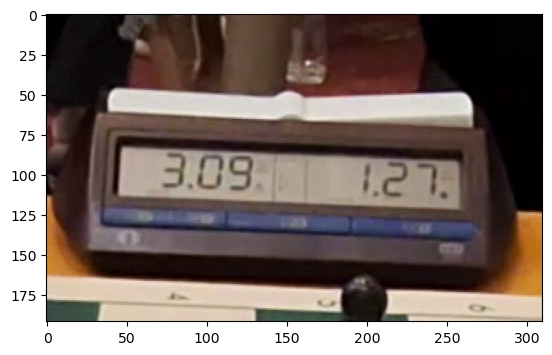

In [143]:
img_file_path = 'data/smth2.png'

# img = plt.imread('data/stock_clock.png')
img = plt.imread(img_file_path)
img_gray = (cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)*255).astype(np.uint8)

print(img.shape)

plt.imshow(img);

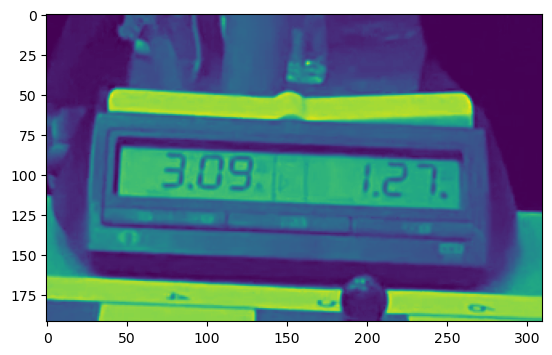

In [144]:
plt.imshow(img_gray);

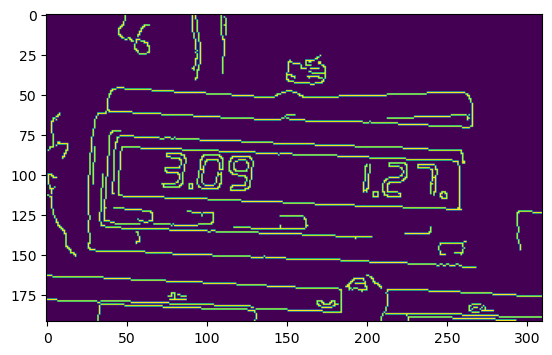

In [145]:
edges = cv2.Canny(img_gray, 100, 200)

plt.imshow(edges);

In [146]:
lines = cv2.HoughLinesP(edges,
                        1,
                        np.pi/180,
                        threshold=30,
                        minLineLength=0,
                        maxLineGap=20)

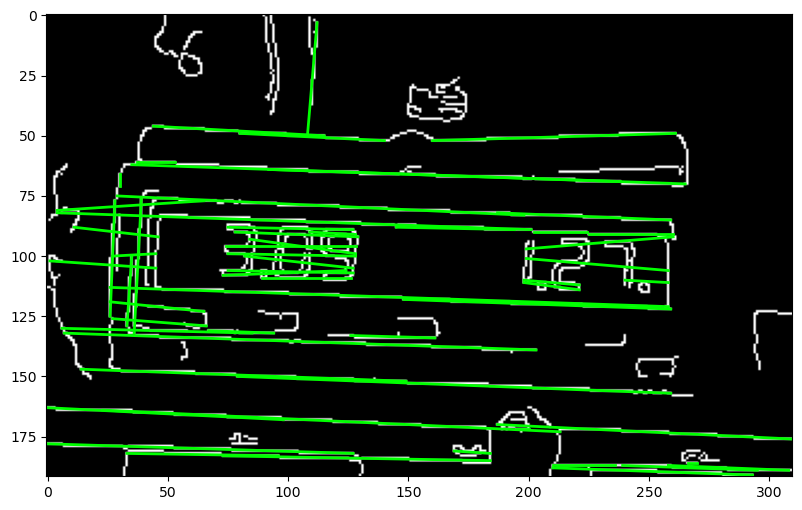

In [147]:
# Plot image
plt.figure(figsize=(10, 6));
plt.imshow(edges, cmap='gray');

# Plot each line with matplotlib
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        plt.plot([x1, x2], [y1, y2], color='lime', linewidth=2);

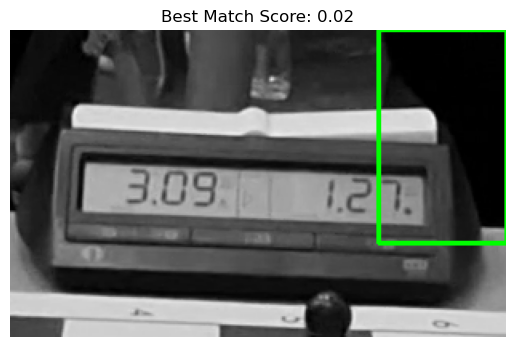

In [148]:
# Load clock crop and template
clock_digit_area = img_gray
template_3 = cv2.imread('data/digit_3.png', 0) # template for digit "3"

# Resize templates if needed to match expected digit size
# template_3 = cv2.resize(template_3, (clock_digit_area.shape[1], clock_digit_area.shape[0]))

# Run template matching
result = cv2.matchTemplate(clock_digit_area, template_3, cv2.TM_CCOEFF_NORMED)

# Find the best match position
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

# Draw rectangle around the best match
h, w = template_3.shape
matched_img = cv2.cvtColor(clock_digit_area, cv2.COLOR_GRAY2BGR)
cv2.rectangle(matched_img, max_loc, (max_loc[0]+w, max_loc[1]+h), (0, 255, 0), 2)

# Display result
plt.imshow(matched_img, cmap='gray')
plt.title(f"Best Match Score: {max_val:.2f}")
plt.axis('off')
plt.show()

In [149]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(img_gray, connectivity=8)
num_labels, labels, stats, centroids, labels.shape, stats.shape, centroids.shape, img_gray.shape

(37,
 array([[1, 0, 0, ..., 7, 7, 0],
        [1, 0, 0, ..., 7, 0, 0],
        [1, 0, 0, ..., 7, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=int32),
 array([[    0,     0,   310,   188,  3399],
        [    0,     0,   310,   192, 54973],
        [    7,     1,     1,     4,     4],
        [    9,     1,     2,     1,     2],
        [  256,     0,     5,     4,    12],
        [  276,     0,     1,     4,     4],
        [  278,     0,     1,     3,     3],
        [  281,     0,    29,    39,   781],
        [    9,     3,     1,     1,     1],
        [  250,     2,     3,     2,     6],
        [  265,     5,     7,     3,     9],
        [  278,     9,     3,     2,     4],
        [  241,    10,     2,     3,     4],
        [  245,    11,     2,     2,     4],
        [  265,    11,    11,    15,    62],
        [    0,    13,     3,     4,     5],
        [  249,    14,     2,     3,     5],
    

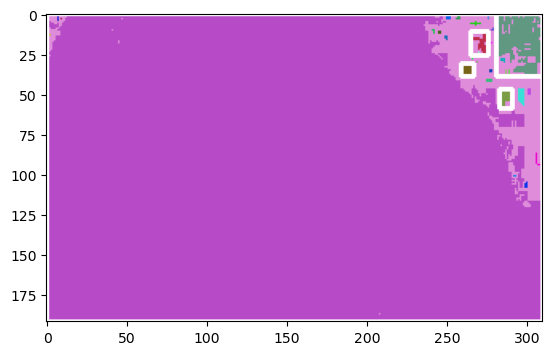

In [150]:
# Create a color map for visualization
output = np.zeros((labels.shape[0], labels.shape[1], 3), dtype=np.uint8)
colors = [np.random.randint(0, 255, size=3).tolist() for _ in range(num_labels)]

for y in range(output.shape[0]):
    for x in range(output.shape[1]):
        output[y, x] = colors[labels[y, x]]

# Optionally draw bounding boxes
for i in range(1, num_labels):  # skip background (label 0)
    x, y, w, h, area = stats[i]
    if area > 50:  # filter small components
        cv2.rectangle(output, (x, y), (x+w, y+h), (255, 255, 255), 2)

# Show results
plt.imshow(output);

In [151]:
img.shape, img.max()

((192, 310, 3), 0.99215686)

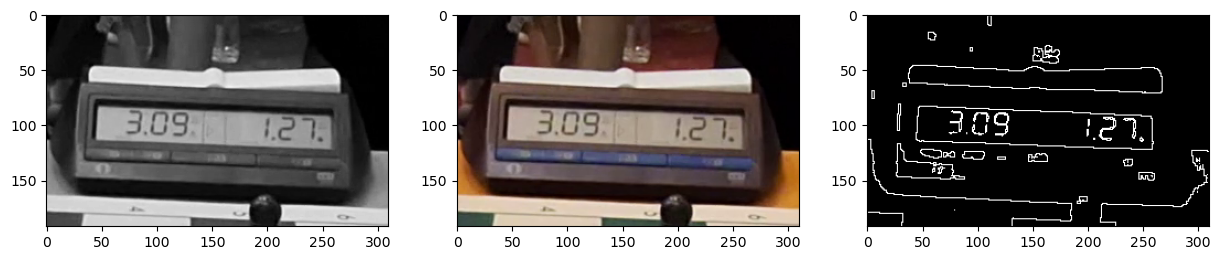

In [152]:
plt.figure(figsize=(15, 6));
plt.subplot(1, 3, 1);
plt.imshow(img_gray, cmap='gray');
plt.subplot(1, 3, 2);
plt.imshow(img);
plt.subplot(1, 3, 3);
img_bin = img.sum(2) < 1.3

eroded = cv2.erode(img_bin.astype(np.uint8), np.ones((3, 3), np.uint8), iterations=1)
diff = img_bin.astype(np.uint8) - eroded
# diff = 1 - diff
# dilated = cv2.dilate(diff, np.ones((3, 3), np.uint8), iterations=1)
# eroded = cv2.erode(dilated, np.ones((3, 3), np.uint8), iterations=1)
# diff = 1 - eroded

plt.imshow(diff, cmap='gray');
plt.imsave('data/diff.png', diff, cmap='gray');

In [153]:
import pytesseract
from PIL import Image

In [154]:
d_img = Image.open('data/diff.png')
print(pytesseract.image_to_string(d_img, config="--psm 6 -c tessedit_char_whitelist=0123456789"))
# print(pytesseract.image_to_boxes(d_img))

309727



In [155]:
import numpy as np

class Segments:
    def __init__(self):
        # create a 7seg model
        self.flags = [];
        self.segments = [];
        h1 = [[0, 1.0],[0, 0.1]];       # 0
        h2 = [[0, 1.0],[0.45, 0.55]];   # 1
        h3 = [[0, 1.0],[0.9, 1.0]];     # 2
        vl1 = [[0, 0.2],[0, 0.5]];      # 3 # upper-left
        vl2 = [[0, 0.2],[0.5, 1.0]];    # 4
        vr1 = [[0.8, 1.0],[0, 0.5]];    # 5 # upper-right
        vr2 = [[0.8, 1.0], [0.5, 1.0]]; # 6
        self.segments.append(h1);
        self.segments.append(h2);
        self.segments.append(h3);
        self.segments.append(vl1);
        self.segments.append(vl2);
        self.segments.append(vr1);
        self.segments.append(vr2);

    # process an image and set flags
    def digest(self, number):
        # reset flags
        self.flags = [];

        # check res to see if it's a one
        h, w = number.shape[:2];
        if w < 0.5 * h:
            self.flags.append(5);
            self.flags.append(6);
            return;

        # check for segments
        for a in range(len(self.segments)):
            seg = self.segments[a];
            # get bounds
            xl, xh = seg[0];
            yl, yh = seg[1];
            # convert to pix coords
            xl = int(xl * w);
            xh = int(xh * w);
            yl = int(yl * h);
            yh = int(yh * h);
            sw = xh - xl;
            sh = yh - yl;
            # check
            count = np.count_nonzero(number[yl:yh, xl:xh] == 255);
            if count / (sh * sw) > 0.5: # 0.5 is a sensitivity measure
                self.flags.append(a);

    # returns the stored number (stored in self.flags)
    def getNum(self):
        # hardcoding outputs
        if self.flags == [0,2,3,4,5,6]:
            return 0;
        if self.flags == [5,6]:
            return 1;
        if self.flags == [0,1,2,4,5]:
            return 2;
        if self.flags == [0,1,2,5,6]:
            return 3;
        if self.flags == [1,3,5,6]:
            return 4;
        if self.flags == [0,1,2,3,6]:
            return 5;
        if self.flags == [0,1,2,3,4,6]:
            return 6;
        if self.flags == [0,5,6]:
            return 7;
        if self.flags == [0,1,2,3,4,5,6]:
            return 8;
        if self.flags == [0,1,2,3,5,6]:
            return 9;
        # ERROR
        return -1;

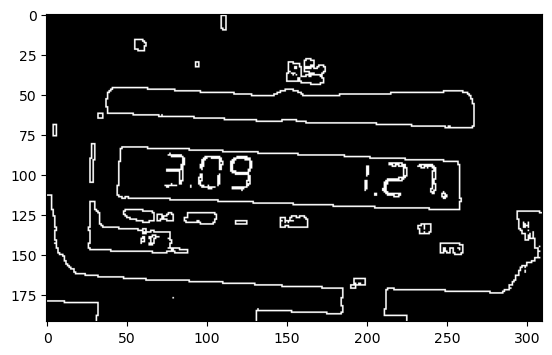

In [156]:
import cv2
import numpy as np

# load image
img = plt.imread("data/diff.png");

# crop
# img = img[300:800,100:800,:];

# lab
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB);
l,a,b = cv2.split(lab);

# show
plt.imshow(img);

# closing operation
kernel = np.ones((5,5), np.uint8);

# threshold params
low = 165;
high = 200;
iters = 3;

# make copy
copy = b.copy();

# threshold
thresh = cv2.inRange(copy, low, high);

# dilate
for a in range(iters):
    thresh = cv2.dilate(thresh, kernel);

# erode
for a in range(iters):
    thresh = cv2.erode(thresh, kernel);

# show image
plt.imshow(thresh);
plt.imsave("threshold.jpg", thresh);

# start processing
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE);

# draw
for contour in contours:
    cv2.drawContours(img, [contour], 0, (0,255,0), 3);

# get res of each number
bounds = [];
h, w = img.shape[:2];
for contour in contours:
    left = w;
    right = 0;
    top = h;
    bottom = 0;
    for point in contour:
        point = point[0];
        x, y = point;
        if x < left:
            left = x;
        if x > right:
            right = x;
        if y < top:
            top = y;
        if y > bottom:
            bottom = y;
    tl = [left, top];
    br = [right, bottom];
    bounds.append([tl, br]);

# crop out each number
cuts = [];
number = 0;
for bound in bounds:
    tl, br = bound;
    cut_img = thresh[tl[1]:br[1], tl[0]:br[0]];
    cuts.append(cut_img);
    number += 1;
    # plt.imshow(str(number), cut_img);

# font 
font = cv2.FONT_HERSHEY_SIMPLEX;

# create a segment model
model = Segments();
index = 0;
for cut in cuts:
    # save image
    plt.imsave(str(index) + "_" + str(number) + ".jpg", cut);

    # process
    model.digest(cut);
    number = model.getNum();
    print(number);
    plt.imshow(cut);

    # draw and save again
    h, w = cut.shape[:2];
    drawn = np.zeros((h, w, 3), np.uint8);
    drawn[:, :, 0] = cut;
    drawn = cv2.putText(drawn, str(number), (10,30), font, 1, (0,0,255), 2, cv2.LINE_AA);
    plt.imsave("drawn" + str(index) + "_" + str(number) + ".jpg", drawn);
    
    index += 1;
    # cv2.waitKey(0);


# show
plt.imshow(img);
plt.imsave("contours.jpg", img);
# cv2.waitKey(0);

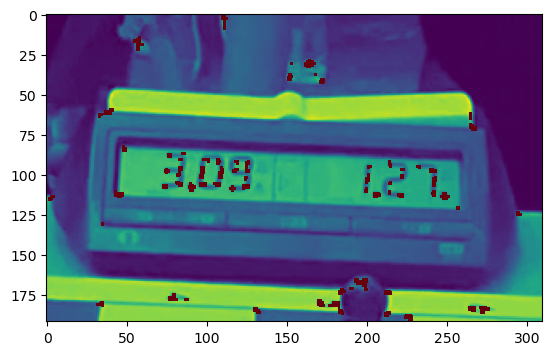

In [157]:
plt.imshow(img_gray);
dst = cv2.cornerHarris(img_gray, 2, 3, 0.04)
# Dilate the corner points to make them more visible
dst = cv2.dilate(dst, None)

# Mark the corners in the original image (Red for corners)
mask = ((dst > 0.01 * dst.max()) * 1).astype(np.uint8)
plt.imshow(mask, alpha=mask, cmap='Reds');

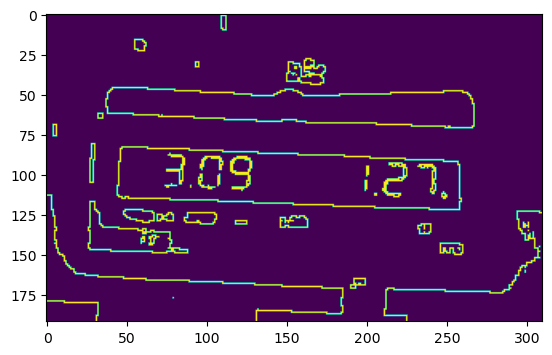

In [158]:
diff_copy = diff.copy()

contours,_ = cv2.findContours(diff_copy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE);
# contours,_ = cv2.findContours(diff_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE);

plt.imshow(diff_copy);

In [159]:
min_area = 0
max_area = 200  # adjust depending on digit size

filtered = [cnt for cnt in contours if min_area <= cv2.contourArea(cnt) <= max_area]
non_filtered = [cnt for cnt in contours if not (min_area <= cv2.contourArea(cnt) <= max_area)]

49


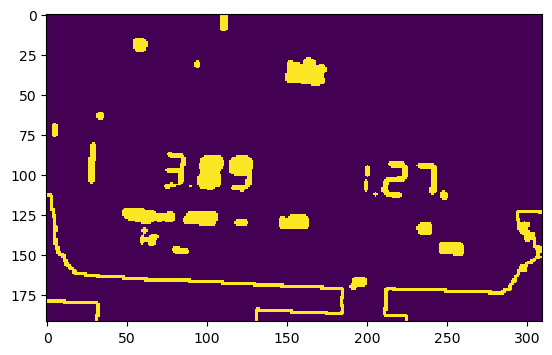

In [160]:
# plt.imshow(diff_copy);
plt.imshow(np.zeros(diff_copy.shape, dtype=np.uint8));

mask = np.zeros(diff_copy.shape, dtype=np.uint8)

# for contour in contours[37:65]:
# for contour in contours:
for contour in filtered:
    cv2.drawContours(mask, [contour], 0, 1, 2);

# plt.imshow(mask, alpha=mask);

combined_contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

mask = np.zeros(diff_copy.shape, dtype=np.uint8)

for contour in combined_contours:
# for contour in combined_contours[19:28]:
# for contour in [combined_contours[25]]:
    cv2.drawContours(mask, [contour], 0, 1, thickness=cv2.FILLED);

plt.imshow(mask, alpha=mask);
print(len(combined_contours))

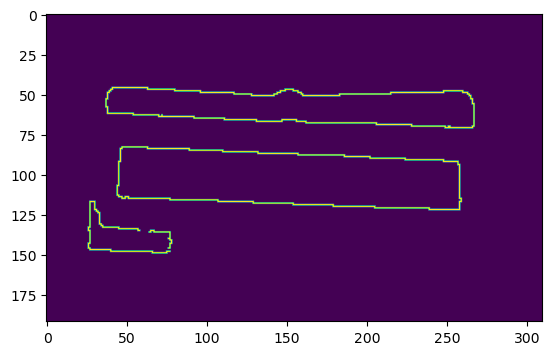

In [161]:
diff2 = diff_copy.copy()
diff2[mask > .5] = 0
plt.imshow(diff2);

86


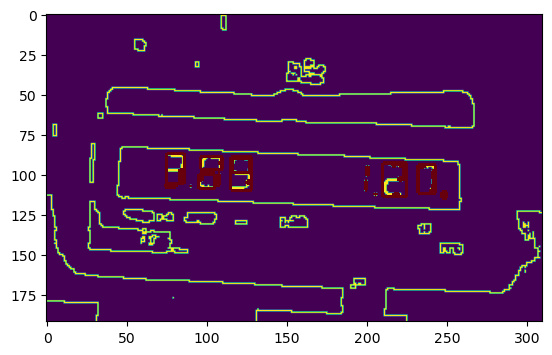

In [162]:
diff_copy = diff.copy()

# get res of each number
bounds = [];
h, w = img.shape[:2];
for contour in contours:
    left = w;
    right = 0;
    top = h;
    bottom = 0;
    for point in contour:
        point = point[0];
        x, y = point;
        if x < left:
            left = x;
        if x > right:
            right = x;
        if y < top:
            top = y;
        if y > bottom:
            bottom = y;
    tl = [left, top];
    br = [right, bottom];
    bounds.append([tl, br]);

print(len(bounds))
bounds_mask = np.zeros(diff_copy.shape, dtype=np.uint8)
# Draw each rectangle on the image
for top_left, bottom_right in bounds[37:65]:
    cv2.rectangle(bounds_mask, top_left, bottom_right, color=1, thickness=2)

plt.imshow(diff_copy);
plt.imshow(bounds_mask, alpha=bounds_mask, cmap='Reds');

In [163]:
img = plt.imread(img_file_path)

((192, 310), (192, 310, 3))

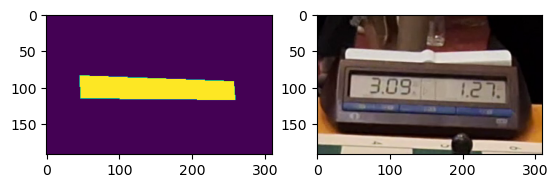

In [164]:
img_new_mask = np.zeros(diff_copy.shape, dtype=np.uint8)

bounds = None

area_max = -1

for cnt in non_filtered:
    epsilon = 0.02 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)

    if len(approx) == 4 and cv2.isContourConvex(approx):
    # if cv2.isContourConvex(cnt):
    # if True:
        # cv2.drawContours(img_new_mask, [cnt], -1, 1, 2)
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = w / h

        # if 1.5 < aspect_ratio < 5.0:  # adjust for your clock's shape
        if True:  # adjust for your clock's shape
            cv2.drawContours(img_new_mask, [approx], -1, 1, thickness=cv2.FILLED)

            area = w * h
            if area > area_max:
                area_max = area
                bounds = cv2.boundingRect(cnt)

plt.subplot(1, 2, 1);
plt.imshow(img_new_mask);
plt.subplot(1, 2, 2);
plt.imshow(img);
img_new_mask.shape, img.shape

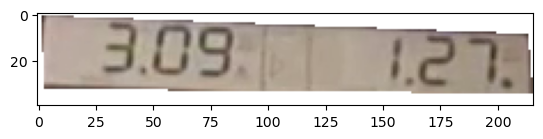

In [165]:
im_copy = img.copy()
im_copy[img_new_mask < 0.1] = [1, 1, 1]  # Change color to green
x, y, w, h = bounds
cropped = im_copy[y:y+h, x:x+w]
plt.imshow(cropped, cmap='Reds');

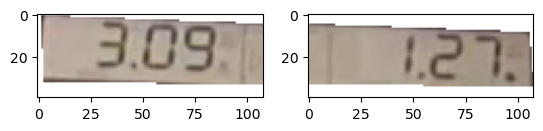

In [166]:
# left
plt.subplot(1, 2, 1)
left_img = cropped[:, :cropped.shape[1]//2]
plt.imshow(left_img);
plt.imsave('data/left_half.jpg', left_img);
# right
plt.subplot(1, 2, 2)
right_img = cropped[:, cropped.shape[1]//2:]
plt.imshow(right_img);
plt.imsave('data/right_half.jpg', right_img);

In [167]:
lft = Image.open('data/left_half.jpg')
print(pytesseract.image_to_string(lft, config="--psm 7 -c tessedit_char_whitelist=0123456789"))

0



0.18163529


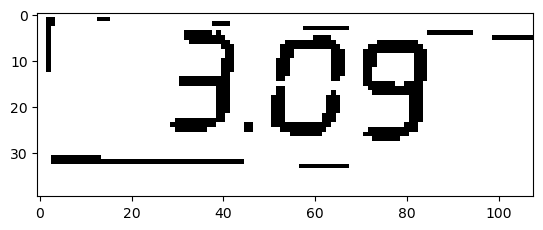

In [176]:
left_adjust = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)
print(left_adjust.min())
left_adjust[left_adjust < 0.5] = 0
left_adjust[left_adjust > 0.5] = 1
plt.imshow(left_adjust, cmap='gray');
plt.imsave('data/left_adjust.jpg', left_adjust, cmap='gray');

In [179]:
lft = Image.open('data/left_adjust.jpg')
print(pytesseract.image_to_string(lft, config="--psm 7 -c tessedit_char_whitelist=0123456789"))

3097



In [ ]:
right_adjust = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)
print(right_adjust.min())
right_adjust[right_adjust < 0.5] = 0
right_adjust[right_adjust > 0.5] = 1
plt.imshow(right_adjust, cmap='gray');
plt.imsave('data/right_adjust.jpg', right_adjust, cmap='gray');